In [1]:
import numpy as np
import torch as pt
from tqdm import tqdm
import time

In [2]:
def flatten_index(i,j, col=None):
    if col is None:
        col = N
    return (i-1)*col + (j-1)
    # grid is (N+2,N+2), the A has to be (N^2, N^2)
def unflatten_index(ind, col=None):
    if col is None:
        col = N+2
    i = ind//col
    j = ind%col
    return (i,j)



def create_A(alpha):
    A = np.zeros((N*N, N*N))

    for i in range(1, N+1): # will run 1 to N, so i-1 will be 0 to N-1
        for j in range(1, N+1):

            center = flatten_index(i, j)

            # main diagonal
            A[center, center] = 1 + 4*alpha

            # neighbors
            if i > 1:      # up
                A[center, flatten_index(i-1, j)] = -alpha
            if i < N:      # down
                A[center, flatten_index(i+1, j)] = -alpha
            if j > 1:      # left
                A[center, flatten_index(i, j-1)] = -alpha
            if j < N:      # right
                A[center, flatten_index(i, j+1)] = -alpha

    return A


def impose_boundary_condition(A,b, alpha, left_B = 0, right_B = 0, down_B = 0): #NxN
    
    for row in range(1,N+1):
        for col in range(1,N+1):
            i = row
            j = col
            if row == 1: # neumann
                up = flatten_index(i-1,j)
                center = flatten_index(i,j)
                A[center,center] -= alpha
            if row == N : # dirichlet
                down = flatten_index(i+1,j)
                center = flatten_index(i,j)
                b[center] += alpha * down_B
            if col == 1 :
                left = flatten_index(i,j-1)
                center = flatten_index(i,j)
                b[center] += alpha * left_B
            if col == N:
                right = flatten_index(i,j+1)
                center = flatten_index(i,j)
                b[center] += alpha * right_B
    return A,b

def flatten_grid(grid, remove_padding=True):
    if remove_padding:
        b = grid[1:N+1, 1:N+1].flatten()
    else:
        b = grid.flatten()
    return b

def unflatten_grid(grid, left_B = 0, right_B = 0, down_B = 0, add_padding=True):
    if add_padding:
        interior = grid.reshape((N,N))
        g = np.zeros((N+2, N+2))
        g[1:N+1, 1:N+1] = interior

        g[1:N+1, 0] = left_B
        g[1:N+1, N+1] = right_B
        g[N+1, 1:N+1] = down_B
        g[0, 1:N+1] = g[1,1:N+1]

        g[0,0] = 0
        g[0,N+1] = 0
        g[N+1,0] = 0
        g[N+1, N+1] = 0
    else:
        g = grid.reshape((N+2,N+2))
    return g

def unflatten_all(b, N, left_B=0, right_B=0, down_B=0):
    # b: shape (N*N, K)
    K = b.shape[1]
    interior = b.reshape(N, N, K)

    out = np.zeros((N+2, N+2, K))
    out[1:N+1, 1:N+1, :] = interior

    out[1:N+1, 0, :] = left_B
    out[1:N+1, N+1, :] = right_B
    out[N+1, 1:N+1, :] = down_B
    out[0, 1:N+1, :] = out[1, 1:N+1, :]  # top copies 1st interior row

    return out

def create_padded_grid(N, timesteps, left_B = 0, right_B = 0, down_B = 0):
    g = np.zeros((N+2,N+2,timesteps))
    g[1:N+1, 0] = left_B
    g[1:N+1, N+1] = right_B
    g[N+1, 1:N+1] = down_B

    g[0,0] = 0
    g[0,N+1] = 0
    g[N+1,0] = 0
    g[N+1, N+1] = 0

    return g

In [6]:
#exp 1, C has same diffusivity and concentration
N=50
delta_x = 0.1
delta_t = 0.05
timesteps = 1000
D_N = 5
D_C = 5
alpha_N = delta_t * D_N / delta_x
alpha_C = delta_t * D_C / delta_x
C_i = 1
N_i = 1
capacity = C_i + N_i
device='cuda'

In [7]:
def compare(N):
    left_B = N_i
    right_B = N_i
    down_B = 0
    grid = create_padded_grid(N,timesteps, left_B = left_B, right_B = right_B, down_B = down_B)
    
    b = np.zeros((N**2,timesteps))
    b[:,0] = flatten_grid(grid[:,:,0])
    b = pt.tensor(b)
    b_ = b[:,0].clone()
    A = create_A(alpha = alpha_N)
    A_gpu, _ = impose_boundary_condition(A,b_, alpha=alpha_N, left_B = left_B, right_B = right_B, down_B = down_B)
    
    start_gpu = time.time()
    A_gpu = pt.tensor(A_gpu).to(device)
    
    for i in tqdm(range(1,timesteps)):
        b_ = b[:,i-1].clone()
        _, b_ = impose_boundary_condition(A,b_, alpha=alpha_N, left_B = left_B, right_B = right_B, down_B = down_B)
        b_ = pt.tensor(b_).to(device)
        x = pt.linalg.solve(A_gpu,b_)
        b[:,i] = x
    
    end_gpu = time.time()
    
    
    b = np.zeros((N**2,timesteps))
    b[:,0] = flatten_grid(grid[:,:,0])
    b_ = b[:,0].copy()
    A = create_A(alpha = alpha_N)
    A_cpu, _ = impose_boundary_condition(A,b_, alpha=alpha_N, left_B = left_B, right_B = right_B, down_B = down_B)
    
    start_cpu = time.time()
    
    for i in tqdm(range(1,timesteps)):
        b_ = b[:,i-1].copy()
        _, b_ = impose_boundary_condition(A,b_, alpha=alpha_N, left_B = left_B, right_B = right_B, down_B = down_B)
        x = np.linalg.solve(A_cpu,b_)
        b[:,i] = x

    end_cpu = time.time()

    return end_gpu-start_gpu, end_cpu-start_cpu
                                     

In [8]:
compare(50)

  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\umang\AppData\Local\Temp\ipykernel_20188\4109019356.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_ = pt.tensor(b_).to(device)
100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [04:04<00:00,  4.09it/s]


(142.74730443954468, 244.00631737709045)

In [9]:
#exp 1, C has same diffusivity and concentration
N=10
delta_x = 0.1
delta_t = 0.05
timesteps = 1000
D_N = 5
D_C = 5
alpha_N = delta_t * D_N / delta_x
alpha_C = delta_t * D_C / delta_x
C_i = 1
N_i = 1
capacity = C_i + N_i
device='cuda'
compare(N)

  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\umang\AppData\Local\Temp\ipykernel_20188\4109019356.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_ = pt.tensor(b_).to(device)
100%|███████████████████████████████████████████████████████████████████████████████| 999/999 [00:01<00:00, 546.46it/s]


(1.5902183055877686, 1.8361339569091797)

In [10]:
#exp 1, C has same diffusivity and concentration
N=20
delta_x = 0.1
delta_t = 0.05
timesteps = 1000
D_N = 5
D_C = 5
alpha_N = delta_t * D_N / delta_x
alpha_C = delta_t * D_C / delta_x
C_i = 1
N_i = 1
capacity = C_i + N_i
device='cuda'
compare(N)

  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\umang\AppData\Local\Temp\ipykernel_20188\4109019356.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_ = pt.tensor(b_).to(device)
100%|███████████████████████████████████████████████████████████████████████████████| 999/999 [00:09<00:00, 108.84it/s]


(4.359179258346558, 9.180349349975586)

In [11]:
#exp 1, C has same diffusivity and concentration
N=30
delta_x = 0.1
delta_t = 0.05
timesteps = 1000
D_N = 5
D_C = 5
alpha_N = delta_t * D_N / delta_x
alpha_C = delta_t * D_C / delta_x
C_i = 1
N_i = 1
capacity = C_i + N_i
device='cuda'
compare(N)

  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\umang\AppData\Local\Temp\ipykernel_20188\4109019356.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_ = pt.tensor(b_).to(device)
100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [00:24<00:00, 40.95it/s]


(15.036248445510864, 24.398936986923218)

In [12]:
#exp 1, C has same diffusivity and concentration
N=40
delta_x = 0.1
delta_t = 0.05
timesteps = 1000
D_N = 5
D_C = 5
alpha_N = delta_t * D_N / delta_x
alpha_C = delta_t * D_C / delta_x
C_i = 1
N_i = 1
capacity = C_i + N_i
device='cuda'
compare(N)

  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\umang\AppData\Local\Temp\ipykernel_20188\4109019356.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_ = pt.tensor(b_).to(device)
100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [02:10<00:00,  7.68it/s]


(45.32199478149414, 130.1164882183075)

In [13]:
size = (10,20,30,40,50)
cpu_time = (1.83, 9.18, 24.39, 130.11, 244)
gpu_time = (1.59, 4.35, 15.03, 45.32, 142)

In [15]:
import matplotlib.pyplot as plt

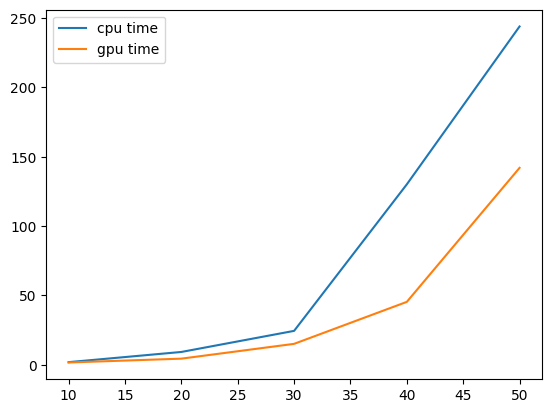

In [20]:
plt.plot(size, cpu_time, label='cpu time')
plt.plot(size, gpu_time, label = 'gpu time')
plt.legend()

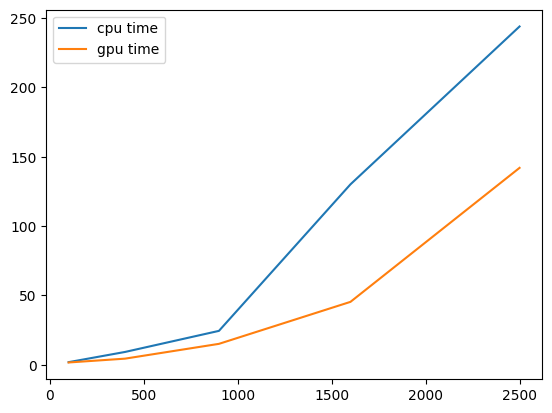

In [24]:
plt.plot(np.array(size)**2, cpu_time, label='cpu time')
plt.plot(np.array(size)**2, gpu_time, label = 'gpu time')
plt.legend()

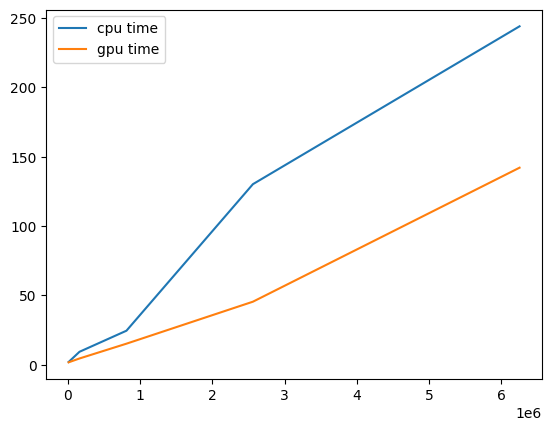

In [23]:
plt.plot(np.array(size)**4, cpu_time, label='cpu time')
plt.plot(np.array(size)**4, gpu_time, label = 'gpu time')
plt.legend()